# Monthly Milk Production in a Farm Time Series Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reading the data
milk = pd.read_csv('monthly-milk-production.csv', index_col='Month')
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [3]:
milk.index = pd.to_datetime(milk.index)
milk.head(2)

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0


In [4]:
# from pandas_profiling import ProfileReport
# ProfileReport(milk)

## Plotting the Data

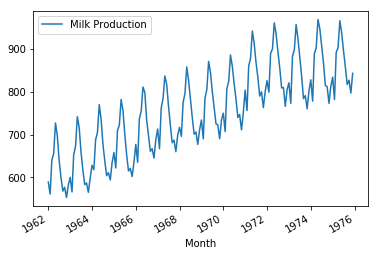

In [5]:
milk.plot() # Since the index is made to be a datetime index, no arg needed

## Preprocessing

### Train Test Split

Since this is a Time Series, train test split should not be randomized. The order of the series should be preserved.

In [6]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


There are 168 entries.

Training on the first 156 months' data and then testing for the last 12 months' data

In [7]:
train_set = milk.head(156)
test_set = milk.tail(12)

### Scaling the data

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

I should fit-transform only on the training set. The test set is assumed to come from unseen source, hence the test set should only be transformed from the scaler object fitted from the training set. Else you are assuming you know about the data from the future.

In [9]:
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

## Creating the Batch Function

Create a batch function to feed the data to the model

It should output a tuple of y time series results ie y[:, :-1] (all rows, 0th column) and y[:, 1:] (all rows of column 1 and up)

Example of Slicing: Apparently, I still get confused of this even after four years of Python

In [10]:
my = np.array([[1,2],[3,4],[5,6]])

In [11]:
my[:, :-1], my[:, 1:]

(array([[1],
        [3],
        [5]]), array([[2],
        [4],
        [6]]))

Back to Creating a bach function

In [12]:
# Returns a tuple of y time series results
def next_batch(training_data, batch_size, steps):
    # Defining the starting point of the batch
    # It can start from 0, but it cant start at the last few points as there will not be 
    # enough data that tails the start point
    # ie Each batch needs to have the same number of steps in it
    rand_start = np.random.randint(0, len(training_data)-steps)
    
    # Create a y_data to this
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    # Return the batches of feature and target reshaped into tensors
    return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

## Make the Recurrent Neural Network

In [13]:
import tensorflow as tf

### Defining the Constants

In [14]:
num_inputs = 1 # 1 feature
num_time_steps = 12 # 1 year
num_neurons = 100
num_outputs = 1 # Just making one sequence
learning_rate = 0.01
num_training_iterations = 1000 # 1000 epochs is enough I guess
batch_size = 1

### Creating Placeholders for the data

In [15]:
X = tf.placeholder(tf.float32, shape=[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32, shape=[None,num_time_steps,num_outputs])

### Creating the Recurrent Neural Network Layer

In [16]:
# Since We need only one output from 100 neurons and not 100 outputs,
# wrap the BasicLSTMCell in the outputProjWrap
cell = tf.contrib.rnn.OutputProjectionWrapper(
            tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons,
                                        activation=tf.nn.relu), 
            output_size=num_outputs)

# Now, make an RNN out of this cell
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


### Loss Function and Optimizer

In [17]:
# Defining the loss metric
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

# Defining the optimizer object with Adam, default parameters (set by Authors Kingma et. al. )
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                  beta1=0.9,
                                  beta2=0.999,
                                  epsilon=1e-08)
# Create train object on the optimizer to minimize the loss
train = optimizer.minimize(loss)

### Global Variables Initializers

In [18]:
init = tf.global_variables_initializer()

### Create a saver object to save the model

In [19]:
saver = tf.train.Saver()

## Running the Session of Recurrent Neural Network

In [20]:
# uncomment if using GPU
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    # Initializing the Variables
    sess.run(init)
    # Training
    for iteration in range(num_training_iterations):
        # Get the data
        X_batch, y_batch = next_batch(training_data=train_scaled, 
                                      batch_size=batch_size,
                                      steps=num_time_steps)
        # run the train object with the data
        sess.run(train, feed_dict={
            X: X_batch,
            y: y_batch
        })
        # Print temporary training loss
        if iteration%100 == 0:
            mse = loss.eval(feed_dict={
                X: X_batch,
                y: y_batch
            })
            print(iteration, "\tMSE: ", mse)
    # Saving the model
    saver.save(sess, "./Milking_a_cow_LSTM_Adam_NoGPU_HighEta")

0 	MSE:  0.07854491
100 	MSE:  0.021405498
200 	MSE:  0.009848952
300 	MSE:  0.009696403
400 	MSE:  0.008601888
500 	MSE:  0.008281783
600 	MSE:  0.0111152455
700 	MSE:  0.006105352
800 	MSE:  0.00727107
900 	MSE:  0.0030675419


## Predicting the Future Milk Production

The test set is the milk production for the last 12 months

In [21]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


### Generative Session

In [25]:
with tf.Session() as sess:
    # Restore the model
    saver.restore(sess, "./Milking_a_cow_LSTM_Adam_NoGPU_HighEta")
    # Seed the generator with the entire training set (scaled)
    train_seed = list(train_scaled[-12:])
    
    for iteration in range(12): # Because I want for the next 12 months
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs, feed_dict={
                                                X: X_batch
                                             })
        train_seed.append(y_pred[0,-1,0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./Milking_a_cow_LSTM_Adam_NoGPU_HighEta


In [27]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.5915539,
 0.6335244,
 0.69343746,
 0.75199676,
 0.7325647,
 0.63079727,
 0.53949916,
 0.47229692,
 0.4279141,
 0.4119555,
 0.41989473,
 0.45344052]

### Transform them Back

In [28]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [29]:
test_set['Generated'] = results

/home/themadscientist/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,799.086426
1975-02-01 01:00:00,782.0,816.546143
1975-03-01 01:00:00,892.0,841.470032
1975-04-01 01:00:00,903.0,865.830627
1975-05-01 01:00:00,966.0,857.746887
1975-06-01 01:00:00,937.0,815.411621
1975-07-01 01:00:00,896.0,777.431641
1975-08-01 01:00:00,858.0,749.475525
1975-09-01 01:00:00,817.0,731.012268


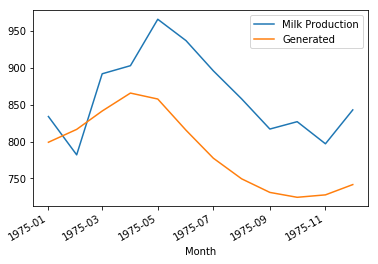

In [31]:
test_set.plot()

Not that bad, but still for something as deterministic as the graph of milk production above, our milk prediction is plain bad. Try to make a Gated Recurrent Unit RecNN with a slower learning rate and predict again.

# Making a Gated Recurrent Unit Solution

In [39]:
tf.reset_default_graph()

num_inputs = 1 # 1 feature
num_time_steps = 12 # 1 year
num_neurons = 100
num_outputs = 1 # Just making one sequence
learning_rate = 0.0001 # Lower than before
num_training_iterations = 8000 # 8000 epochs for this
batch_size = 1

X = tf.placeholder(tf.float32, shape=[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32, shape=[None,num_time_steps,num_outputs])

# Since We need only one output from 100 neurons and not 100 outputs,
# wrap the BasicLSTMCell in the outputProjWrap
cell = tf.contrib.rnn.OutputProjectionWrapper(
            tf.contrib.rnn.GRUCell(num_units=num_neurons,
                                        activation=tf.nn.relu), 
            output_size=num_outputs)

# Now, make an RNN out of this cell
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# Defining the loss metric
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

# Defining the optimizer object with Adam, default parameters (set by Authors Kingma et. al. )
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                  beta1=0.9,
                                  beta2=0.999,
                                  epsilon=1e-08)
# Create train object on the optimizer to minimize the loss
train = optimizer.minimize(loss)

# Init object
init = tf.global_variables_initializer()

# Saver object
saver = tf.train.Saver()

## Training the Gated Recurrent Unit RecNN

In [40]:
# uncomment if using GPU
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    # Initializing the Variables
    sess.run(init)
    # Training
    for iteration in range(num_training_iterations):
        # Get the data
        X_batch, y_batch = next_batch(training_data=train_scaled, 
                                      batch_size=batch_size,
                                      steps=num_time_steps)
        # run the train object with the data
        sess.run(train, feed_dict={
            X: X_batch,
            y: y_batch
        })
        # Print temporary training loss
        if iteration%100 == 0:
            mse = loss.eval(feed_dict={
                X: X_batch,
                y: y_batch
            })
            print(iteration, "\tMSE: ", mse)
    # Saving the model
    saver.save(sess, "./Milking_a_cow_GRU_Adam_NoGPU_LowEta")

0 	MSE:  0.14305834
100 	MSE:  0.09964601
200 	MSE:  0.028703948
300 	MSE:  0.08477362
400 	MSE:  0.03430243
500 	MSE:  0.03961331
600 	MSE:  0.0418949
700 	MSE:  0.025013534
800 	MSE:  0.012689598
900 	MSE:  0.018125035
1000 	MSE:  0.0105835
1100 	MSE:  0.030633388
1200 	MSE:  0.010638653
1300 	MSE:  0.028363204
1400 	MSE:  0.032172237
1500 	MSE:  0.025877519
1600 	MSE:  0.017491404
1700 	MSE:  0.023364186
1800 	MSE:  0.012690611
1900 	MSE:  0.022271015
2000 	MSE:  0.0087156845
2100 	MSE:  0.008368222
2200 	MSE:  0.0169458
2300 	MSE:  0.024863027
2400 	MSE:  0.016567314
2500 	MSE:  0.014812801
2600 	MSE:  0.012036655
2700 	MSE:  0.00934241
2800 	MSE:  0.0175597
2900 	MSE:  0.010778982
3000 	MSE:  0.011239514
3100 	MSE:  0.014668857
3200 	MSE:  0.009450961
3300 	MSE:  0.03004655
3400 	MSE:  0.02302899
3500 	MSE:  0.005435186
3600 	MSE:  0.0062212176
3700 	MSE:  0.0054487456
3800 	MSE:  0.013962116
3900 	MSE:  0.009536757
4000 	MSE:  0.009647893
4100 	MSE:  0.0084069865
4200 	MSE:  0.00

### Generating the Result

In [41]:
with tf.Session() as sess:
    # Restore the model
    saver.restore(sess, "./Milking_a_cow_GRU_Adam_NoGPU_LowEta")
    # Seed the generator with the entire training set (scaled)
    train_seed = list(train_scaled[-12:])
    
    for iteration in range(12): # Because I want for the next 12 months
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs, feed_dict={
                                                X: X_batch
                                             })
        train_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./Milking_a_cow_GRU_Adam_NoGPU_LowEta


In [42]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [43]:
test_set['Generated'] = results

/home/themadscientist/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


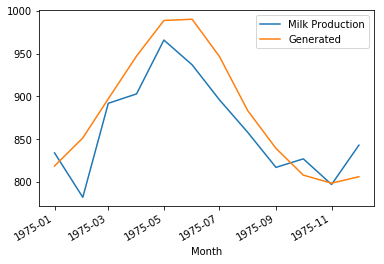

In [44]:
test_set.plot()

Meh, Better